# Geometric Low-Rank Tensor Completion

**Published**: October 27, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**geotensor**](https://github.com/xinychen/geotensor/blob/master/GLTC+.ipynb).

----------------

Geometric Low-rank Tensor Completion (GLTC+) is an approach of reconstructing missing values within tensors. In particular, this approach could use the graphs as side information in form of regularizer.


## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

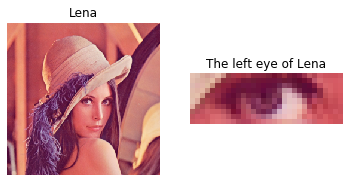

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('data/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye. The pixels of the left eye is apparent.

## Selected Images

We will carry out our image inpainting experiments on the following images.

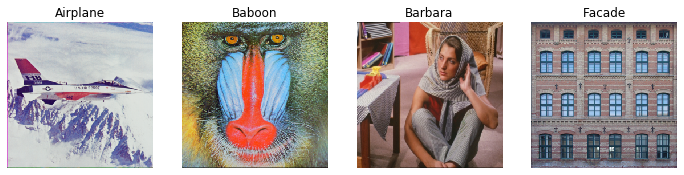

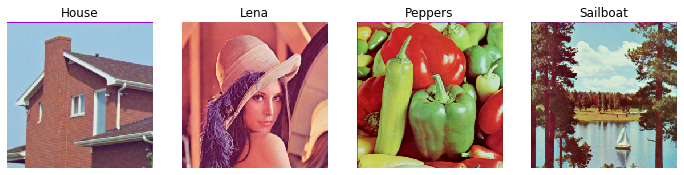

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Low-Rank Tensor Completion

We start by importing the necessary dependencies. We will make use of `numpy`.

In [4]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Soft Thresholding Method

Reference:

Ryan Tibshirani, 2015. Lecture on Proximal Gradient Descent. [[**link**](http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)]

In [7]:
def soft_thresholding(mat, lambda0): ## LSP regularization (nonconvex)
    theta = 0.00001
    gamma = min(lambda0 / theta, theta)
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - gamma
    pos = np.where(vec < 0)
    s[pos] = 0
    
    return np.matmul(np.matmul(u, np.diag(s)), v)

In [8]:
def GLTC(dense_tensor, sparse_tensor, beta, rho, maxiter):
    
    alpha = 1
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1, dim1))
    for i in range(dim1 - 1):
        D1[i+1, i] = -1
        D1[i+1, i+1] = 1
    D2 = np.zeros((dim2, dim2))
    for i in range(dim2 - 1):
        D2[i+1, i] = -1
        D2[i+1, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(soft_thresholding(ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k), 
                                                      alpha / rho), np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Generalized singular value thresholding

In [9]:
def f_func(s_hat, s, lambda0, theta):
    return (0.5 * (s_hat - s)**2 + lambda0 * np.log(s_hat/theta+1))
def delta_g(s_hat, lambda0, theta):
    return lambda0/ (s_hat + theta)

def GSVT_LSP(mat, lambda0, theta):
#     theta = 0.001
    gamma = min(lambda0 / theta, theta)
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - gamma
    pos = np.where(vec < 0)
    s[pos] = 0
    positiveNum = len(s) - len(pos[0])
    for i in range(positiveNum):
        if delta_g(s[i], lambda0, theta) == 0:
            s_hat = s[i]
        else:
            s_hat = s[i]
            s_pre = s_hat + 100
            while abs(s_hat - s_pre) >= 0.0000000001:
                s_pre = s_hat
                s_hat = s[i] - delta_g(s_hat, lambda0, theta)
                if s_hat < 0:
                    s_hat = 0
                    break
        if s_hat != 0:
            if f_func(s_hat, s[i], lambda0, theta) > f_func(0, s[i], lambda0, theta):
                s_hat = 0
        s[i] = s_hat
    
    return np.matmul(np.matmul(u, np.diag(s)), v)

In [10]:
def GLTC_LSP(dense_tensor, sparse_tensor, beta, rho, maxiter, alpha, theta):
    
#     alpha = 5
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1, dim1))
    for i in range(dim1 - 1):
        D1[i+1, i] = -1
        D1[i+1, i+1] = 1
    D2 = np.zeros((dim2, dim2))
    for i in range(dim2 - 1):
        D2[i+1, i] = -1
        D2[i+1, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(GSVT_LSP(ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k), 
                                                      alpha / rho, theta), np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Experiments on Color Images

In the following, we will illustrate the performance of image inpainting tasks using Geometric Low-rank Tensor Completion (GLTC) model on some color images.

We set the missing scenario as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we run the code for 10 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

In [18]:
name0 = ["lena"]
name = ["lena_rcmar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [19]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 0.001
alpha = 3
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_LSP(image, sparse_image, beta, rho, maxiter, alpha, theta)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

8.509064486266722


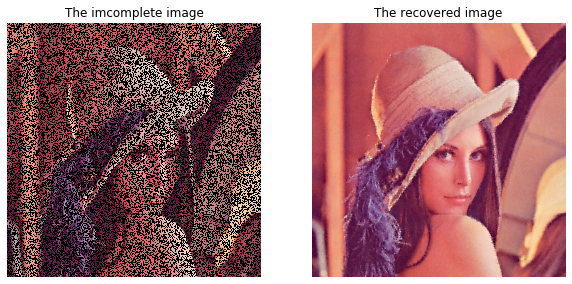

In [13]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

**Experiment results** of image inpainting using GLTC-LSP:

|  scenario | `regularizer`|`theta` | `alpha` |  `rho`  |`maxiter`|        `rse` |
|:----------|-------------:|-------:|--------:|--------:|--------:|-------------:|
|  **MAR**  |      **LSP** |  0.001 |       5 |    0.01 |    1000 | **6.8337646**|
|  **MAR**  |      **LSP** |  0.001 |       4 |    0.01 |    1000 | **6.8201004**|
|  **MAR**  |      **LSP** |  0.005 |       3 |    0.01 |    1000 | **6.8173824**|
|  **MAR**  |      **LSP** |  0.002 |       3 |    0.01 |    1000 | **6.8184693**|
|  **MAR**  |      **LSP** |**0.001**|   **3** | **0.01**|**1000**| **6.8165667**|
|  **MAR**  |      **LSP** |  0.0005|       3 |    0.01 |    1000 | **6.8188415**|
|  **MAR**  |      **LSP** |  0.001 |       3 |   0.005 |    1000 | **6.8513976**|
|  **MAR**  |      **LSP** |  0.001 |       3 |    0.05 |    1000 | **6.8659298**|
|  **MAR**  |      **LSP** |  0.001 |       2 |    0.01 |    1000 | **6.8291496**|
| **R-MAR** |      **LSP** |  0.001 |       3 |    0.01 |    1000 | **8.4247780**|

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using GLTC (Capped-$\ell_1$):

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     6.89      |       8.20     |   11.02   |      8.51      |
|**peppers**|     ~      |      ~     |   ~   |      ~      |


### Whole Performance

We choose the images of `house`, `lena`, `peppers`, and `sailboat` for evaluation.

#### MAR (Missing at random)

In [12]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 0.001
alpha = 3
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GLTC_LSP(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [68]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)

[[6.19280224 6.95064048 8.19780997]]

[[0.07111525 0.07105532 0.09088632]]


#### R-MAR (Row-wise missing at random)

In [14]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [15]:
error = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
print(error)

[[ 7.11677491  8.88114798 12.89398511]
 [ 9.00572784 11.36485136 14.63363052]]


#### C-MAR (Column-wise missing at random)

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [17]:
error = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
print(error)

[[ 8.56348962 10.24430977 15.07030053]
 [ 9.49776294 11.48160295 18.02077292]]


#### RC-MAR

In [18]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [19]:
error = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
print(error)

[[ 7.54142829  8.44481248 10.1913689 ]
 [ 8.78914587 10.16310856 12.04637675]]


Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using GLTC (LSP):

|   -  | Scenario |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:-----|:----------|--------------:|---------------:|----------:|---------------:|
| **Lena** | **30%**   |     6.17      |       9.17     |  9.15     |       8.48     |
|   -  | **50%**   |     6.98      |      10.67     | 11.20     |       9.62     |
|   -  | **70%**   |     8.18      |      15.50     | 15.99     |      11.67     |
| **Peppers** | **30%**   |     6.83      |       9.17     |  9.15     |       8.48     |
|   -  | **50%**   |     7.93      |      10.67     | 11.20     |       9.62     |
|   -  | **70%**   |     9.71      |      15.50     | 15.99     |      11.67     |